# Model 3
## Convolutional Neural Network with Tensorflow

# Libraries

In [1]:
import glob

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from PIL import Image

import matplotlib.pyplot as plt

import csv

# Read Images Function

In [4]:
def ReadImages(path, get_labels=True):
	'''
	This functions read all images from a folder (using PIL library) and return them as a numpy array.
	All images are resized to 32x32 pixels, in accordance with the LeNet 5 structure.

	@path: Path where the images are store
	@get_labels: Ween set to True, the function will try to get the label from the image name (the digits after the last _ chatacter). 

	return a numpy array for the images and another one for the labels (in case it is necessary)
	'''
	print("Reading Images...")

	#Complete the path in case is incomplete
	if path[-1] != '/':
		path += '/'


	#Read images from folder
	images_paths = glob.glob(path+'*.ppm')

	#Initialize lists
	images = []
	labels = []

	#Loop around all images on the folder
	cont = 0
	for image_path in images_paths:
		#Open image with PIL
		image = Image.open(image_path)
		#Resize Image
		image = image.resize((32,32))

		#Convert image to array, then reshape it in the form WidthxHeightxChannels.
		#Append the image to the images list
		images.append(np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)/255)

		#If get_labels is set to True, get the image label
		if get_labels:
			pos1 = image_path.rfind('_')+1 #Find the position of the last _ character
			pos2 = image_path.find('.', pos1) #Find the position of the . character
			labels.append(int(image_path[pos1:pos2])) #Get the label and append it to the labels list

		cont += 1 #Increase counter
		#If the counter is a multiple of 1000, print
		if cont%5000 == 0:
			print(cont, "/", len(images_paths))
		#elif cont > 3000:
		#	break		

	#Convert images list to numpy array	
	images = np.asarray(images)
	
	#If get_labels is set to True, return images and labels, otherwise returns just images
	if get_labels:
		labels = np.asarray(labels)
		return images, labels
	else:
		return images	


**Examples:**

In [6]:
ReadImages('../images/test')

Reading Images...
5000 / 16775
10000 / 16775
15000 / 16775


(array([[[[0.03921569, 0.03137255, 0.03921569],
          [0.03529412, 0.03137255, 0.03921569],
          [0.04705882, 0.03921569, 0.04705882],
          ...,
          [0.03921569, 0.03137255, 0.04313725],
          [0.03921569, 0.03529412, 0.05098039],
          [0.03921569, 0.03529412, 0.04313725]],
 
         [[0.03529412, 0.03137255, 0.04313725],
          [0.03921569, 0.03137255, 0.04313725],
          [0.03921569, 0.03529412, 0.04313725],
          ...,
          [0.03529412, 0.03137255, 0.03921569],
          [0.03137255, 0.03137255, 0.03921569],
          [0.03137255, 0.03137255, 0.04313725]],
 
         [[0.03529412, 0.03529412, 0.04705882],
          [0.03529412, 0.03137255, 0.04313725],
          [0.03529412, 0.03137255, 0.04313725],
          ...,
          [0.03921569, 0.03529412, 0.04313725],
          [0.03921569, 0.03529412, 0.03921569],
          [0.03529412, 0.03137255, 0.04313725]],
 
         ...,
 
         [[0.03137255, 0.02745098, 0.04313725],
          [0.02745

# CNN Classes Definitions

## Layers

In [7]:
class OutputLayer(object):
	'''
	Output Layer class
	Methods:
		__init__: Initialize the layer
		forward: Perform a forward step of the layer
	'''
	def __init__(self, M1, M2):
		'''
		Initialize the weights and bias of the layer
		@M1: Number of input nodes.
		@M2: Number of output classes.
		'''
		#Define tensorflow variables (weight and bias)
		self.M1 = M1
		self.M2 = M2
		W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
		b = np.zeros(M2)
		self.W = tf.Variable(W.astype(np.float32))
		self.b = tf.Variable(b.astype(np.float32))

	def forward(self, X):
		'''
		Perform a forward step of the layer without any activation function
		@X: Numpy a array the is the input of the layer

		returns the output of the layer
		'''
		#Return (X·W+b)
		return tf.matmul(X, self.W) + self.b

class FullyConnectedLayer(object):
	'''
	Fully connected Layer class
	Methods:
		__init__: Initialize the layer
		forward: Perform a forward step of the layer
	'''
	def __init__(self, M1, M2, activation):
		'''
		Initialize the weights and bias of the layer
		@M1: Number of input nodes.
		@M2: Number of output nodes.
		@activation: Activation function for the layer.
		'''

		#Define tensorflow variables (weight and bias)
		self.M1 = M1
		self.M2 = M2
		W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
		b = np.zeros(M2)
		self.W = tf.Variable(W.astype(np.float32))
		self.b = tf.Variable(b.astype(np.float32))

		#Define activation as a property of the element
		self.f = activation

	def forward(self, X):
		'''
		Perform a forward step of the layer
		@X: Numpy a array the is the input of the layer

		returns the output of the layer
		'''
		#Return f((X·W+b))
		return self.f(tf.matmul(X, self.W) + self.b)

class ConvLayer(object):
	'''
	Convolutional Layer class
	Methods:
		__init__: Initialize the layer
		forward: Perform a forward step of the layer
	'''
	def __init__(self, cnn_filter, pooling, activation):
		'''
		Initialize the weights and bias of the layer
		@cnn_filter: List of 4 elements. The first two elements are the neighborhood connection size. The last two elements are the size of the feature map (input and output)
		@pooling: List of 4 elements. This are the neighborhood connection size for the sub-sampling layer.
		@activation: Activation function for the layer
		'''

		#Define tensorflow variables (weight and bias)
		self.W = tf.Variable((np.random.randn(*cnn_filter) * np.sqrt(2.0 / np.prod(cnn_filter[:-1]))).astype(np.float32))
		self.b = tf.Variable(np.zeros(cnn_filter[3]).astype(np.float32))

		#Define the pooling and activation as properties of the element
		self.pooling = pooling
		self.f = activation

	def forward(self, X):
		'''
		Perform a forward step of the layer
		@X: Numpy a array the is the input of the layer

		returns the output of the layer
		'''
		
		#Convolutional part
		conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
		#Add the bias
		conv_out = tf.nn.bias_add(conv_out, self.b)

		#Sub-sampling (Pooling) part
		pool_out = tf.nn.max_pool(conv_out, ksize=self.pooling, strides=[1, 2, 2, 1], padding='SAME')
		
		#Return the output using the activation function specified
		return self.f(pool_out)


## CNN

In [12]:
class CNN(object):
	"""
	This class represents a Convolutional Neural Network
	It allows to initalize the structure of the network as well as predict and train
	Methods:
		__init__: Initialize the structure of the network
		fit: Perform the training process over the network
		predict: Predict the classes of images
		score: Calculate the accuracy over a test of images
		forward: Perform the forward propagation stage of the network
	"""
	def __init__(self, Width, Height, C, K):
		'''
		Initialize structure of the network
		@Width: Width of images in pixels
		@Height: Height of images in pixels
		@C: Number of channels of images
		@K: Number of output classes
		'''

		#Initialize the place holders for inputs and labels.
		self.inputs = tf.placeholder(tf.float32, shape=(None, Width, Height, C), name='inputs')
		self.labels = tf.placeholder(tf.int64, shape = (None, ), name='labels')


		#Initialize a list for convolutional layers and fully connected layers
		self.conv_layers = []
		self.layers = []

		#1st layer (C1 and S2)
		in_f = C #Input features
		out_f = 6 #Output features
		conv_layer = ConvLayer([5,5,in_f, out_f], pooling=[1, 2, 2, 1], activation=tf.nn.relu) #initialize a ConvLayer element
		self.conv_layers.append(conv_layer) #Append layer to the conv_layers list

		#2nd layer (C3 and S4)
		in_f = out_f #Input features
		out_f = 16 #Output features
		conv_layer = ConvLayer([5,5,in_f, out_f], pooling=[1, 2, 2, 1], activation=tf.nn.relu) #initialize a ConvLayer element
		self.conv_layers.append(conv_layer) #Append layer to the conv_layers list

		#3rd layer (C5)
		#This layers is defined in agreement to the specificatios of the LeNet5. Nevertheless, it behaves different as the current structure uses all 3 RGB channels, while on the LeCuu paper this layer behaved as a fully connected one. 
		in_f = out_f #Input features
		out_f = 120 #Output features
		conv_layer = ConvLayer([5,5,in_f, out_f], pooling=[1, 2, 2, 1], activation=tf.nn.relu) #initialize a ConvLayer element
		self.conv_layers.append(conv_layer) #Append layer to the conv_layers list

		#4th layer (F6)
		M1 = 120*4*4 #Input features
		M2 = 84 #Output features
		layer = FullyConnectedLayer(M1, M2, activation=tf.nn.tanh) #initialize a FullyConnectedLayer element
		self.layers.append(layer) #Append layer to the layers list

		#5th layer (Output)
		M1 = M2 #Input features
		M2 = K #Output features
		layer = OutputLayer(M1, M2) #initialize a OutputLayer element
		self.layers.append(layer) #Append layer to the layers list


		self.logits = self.forward(self.inputs) #The logits are defined as calling the forward function

		#A prediction takes the logits and apply softmax to them. Then it obtain the class with greater probability by applying the argmax
		self.prediction = tf.argmax(tf.nn.softmax(self.logits),1) 

		#The cost function uses the cross entropy function. It already includes the softmax operation over the logits
		self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.labels))

	def forward(self, X):
		'''
		This function performs the forward propagation algorithm over a set of features.
		@X: Numpy array (NxWxHxC) with th set of features

		return a numpy array of Nxn_classes
		'''
		Z = X

		#Loop around all convolutional layers
		for layer in self.conv_layers:
			#Call the forward method for every layer
			Z = layer.forward(Z)

		#Flatten the result from the last convolutional layer so it can be input on the first fully connected layer	
		Z = tf.contrib.layers.flatten(Z)
		
		#Loop around all fully connected layers	and teh output layer	
		for layer in self.layers:
			#Call the forward method for every layer
			Z = layer.forward(Z)

		return Z	

	def fit(self, X, Y, Xtest=[], Ytest=[], load_file='models/model3/saved/model3'):	
		'''
		This function performs the training process of the neural network
		@X: Training images
		@Y: Training labels
		@Xtest and Ytest(optional): If available the code will calculate the cost an accuracy on the testing dataset while training.
		'''

		#Set the size of an image
		N, Width, Height, C = X.shape

		lr = 1e-4 #Learning rate
		decay = 0.9 #Decay
		mu = 0.9 #Momentum

		#Optimizer
		train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(self.cost)
		#train_op = tf.train.MomentumOptimizer(lr, momentum=mu).minimize(self.cost) 
		# train_op = tf.train.AdamOptimizer(lr).minimize(self.cost)
		# train_op = tf.train.GradientDescentOptimizer(lr).minimize(self.cost)

		#Initialize the tensorflow variables
		init = tf.global_variables_initializer()
		#Initalize tensroflow saver
		saver = tf.train.Saver(max_to_keep=1)

		batch_sz = 500 #batch size
		iteration = 0  #Iteration
		max_iterations = 10000 #Max number of iterations
		costs = [] #Costs list

		with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session: #With GPU
		#with tf.Session() as session:	#With CPU only
			if load_file == '':
				session.run(init) #start tensorflow session
			else:
				saver.restore(session, load_file)	

			#Loop around all iterations
			while iteration < max_iterations:
				
				X, Y = shuffle(X, Y) #Shuffle X and Y arrays

				for e in range(0, N, batch_sz): #Epoch loop

					iteration += 1 #Increase iteration

					#Select the X and Y values for the current batch
					Xbatch = X[e:e+batch_sz]
					Ybatch = Y[e:e+batch_sz]

					#Perform the train operation
					session.run(train_op, feed_dict={self.inputs:Xbatch, self.labels:Ybatch})

					#Every 20 iterations, print and save
					if iteration%20 == 0:

						#Get the cost and accuracy for current batch 
						c, p = session.run((self.cost, self.prediction), feed_dict={self.inputs:Xbatch, self.labels:Ybatch})
						acc = accuracy_score(Ybatch, p)

						#Initialize testing results
						c_test, p_test = (0,0)
						acc_test = 0

						#If there is a testing set, get the cost and accuracy of it
						if len(Xtest)>0:
							c_test, p_test = session.run((self.cost, self.prediction), feed_dict={self.inputs:Xtest, self.labels:Ytest})
							acc_test = accuracy_score(Ytest, p_test)
						
						#Print the costs and accuracies for both tests
						print(iteration,"Costs:", c, c_test, "Accuracy:", acc, acc_test)	

						#Save the tensorflow model
						saver.save(session, '../models/model3/saved/model3')

						#Save the costs
						costs.append([iteration, c, c_test, acc, acc_test])
						with open('../models/model3/saved/costs.csv', 'w') as fp:
							a = csv.writer(fp, delimiter=',')
							a.writerows(costs) 

			#Save the tensorflow model				
			saver.save(session, '../models/model3/saved/model3')			

	def predict(self, X):
		'''
		This functions predic the classes form a set of images X
		@X: Images in a 4D numpy array 

		returns a numpy array of size (Nx1) with the class of each image
		'''

		#Initialize tensorflow variables and saver
		init = tf.global_variables_initializer()
		saver = tf.train.Saver()

		#Initialize Tensorflow session
		#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session: #GPU
		with tf.Session() as session:	#CPU-only
			#Load tensorflow model
			load_file = '../models/model3/saved/model3'
			saver.restore(session, load_file)

			#Predict the classes
			pred = session.run(self.prediction, feed_dict={self.inputs:X})

		return pred	

	def score(self, X, Y):
		'''
		Evaluate the accuracy of the prediction over a set of images
		@X: Images in a 4D numpy array 
		@Y: Images classes in a 1D numpy array 
		'''
		pred = self.predict(X) #Predict the classes of the images

		#Get the accuracy of the prediction
		return accuracy_score(Y, pred)	


# Model Function

In [19]:
def model3(c_type, image_path):
	'''
	This model identify what operation is goind to be perform with the model3 (train, test or infer) and call the a function in accordance.
	@c_type: Operation type. It could be train, test or infer
	@image_path: Path to the images folder
	'''

	model_path = 'models/model3/saved/model3' #Path where the model is saved

	if c_type == 'train':
		#Call ReadImages function
		X, Y = ReadImages(image_path)
		Xtest, Ytest = ReadImages('images/test/')

		#Get the size of the images array 
		N, Width, Height, C = X.shape
		#Get the number of classes
		K = len(set(Y))

		#Initialize the CNN element
		NN = CNN(Width, Height, C, K)
		#Call the fit method of the CNN element
		NN.fit(X, Y, Xtest, Ytest)

	elif c_type == 'test':
		#Call ReadImages function
		X, Y = ReadImages(image_path)
		#Get the size of the images array 
		N, Width, Height, C = X.shape
		#Get the number of classes
		K = len(set(Y))	

		#Initialize the CNN element
		tf.reset_default_graph()        
		NN = CNN(Width, Height, C, K)
		#Call and print the scire method of the CNN element
		print("Accuracy:", NN.score(X, Y))

	elif c_type == 'infer':
		#Call ReadImages function
		images_paths = ReadImages(image_path, False)	
		#Get the size of the images array 
		N, Width, Height, C = images_paths.shape
		#Initialize the CNN element
		tf.reset_default_graph()        
		NN = CNN(Width, Height, C, 43)

		#Loop around all images in steps of 9
		for i in range(0, len(images_paths), 9):

			subplot_images = images_paths[i:i+9] #Select the following 9 images
			results = NN.predict(subplot_images) #Predict their classes
			#Add images to a matplotlib plot
			index = 0
			for image in subplot_images:
				result = results[index]
				index += 1
				plt.subplot(3,3,index)
				plt.title("Class "+str(result))
				plt.axis('off')
				plt.imshow(image)

			plt.show() #Show the plot with the 9 images and their classes

			#Ask the user if he which to continue with the following 9 images
			inputted = input("Continue? (y/n)")
			if inputted.lower() != 'y':
				break



# Examples:

## Test

In [20]:
model3('test', '../images/test/')

Reading Images...
5000 / 16775
10000 / 16775
15000 / 16775
INFO:tensorflow:Restoring parameters from ../models/model3/saved/model3
Accuracy: 0.9972578241430701


## Infer

Reading Images...
5000 / 16775
10000 / 16775
15000 / 16775
INFO:tensorflow:Restoring parameters from ../models/model3/saved/model3


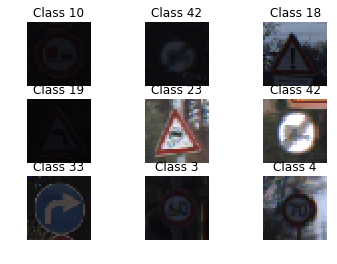

Continue? (y/n)y
INFO:tensorflow:Restoring parameters from ../models/model3/saved/model3


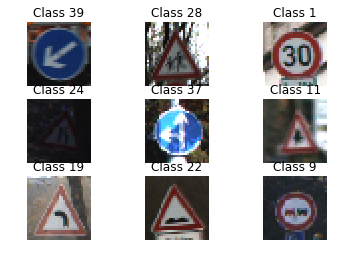

Continue? (y/n)y
INFO:tensorflow:Restoring parameters from ../models/model3/saved/model3


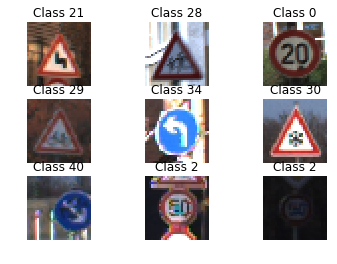

Continue? (y/n)n


In [18]:
model3('infer', '../images/test/')